# Google Cloud ML Tutorial
미래에셋증권 빅데이터 페스티벌을 위한 Vertex AI Workbench 샘플 노트북

## IRIS 붓꽃 분석하기

### Vertex AI Workbench 노트북 세팅

In [1]:
import os

# The Google Cloud Notebook product has specific requirements
IS_GOOGLE_CLOUD_NOTEBOOK = os.path.exists("/opt/deeplearning/metadata/env_version")

# Google Cloud Notebook requires dependencies to be installed with '--user'
USER_FLAG = ""
if IS_GOOGLE_CLOUD_NOTEBOOK:
    USER_FLAG = "--user"

In [2]:
! pip install {USER_FLAG} --upgrade google-cloud-aiplatform

  Using cached google_cloud_aiplatform-1.16.1-py2.py3-none-any.whl (2.2 MB)
  Attempting uninstall: google-cloud-aiplatform
    Found existing installation: google-cloud-aiplatform 1.13.0
    Uninstalling google-cloud-aiplatform-1.13.0:
ERROR: Could not install packages due to an OSError: [Errno 13] Permission denied: 'jobs.py'
Consider using the `--user` option or check the permissions.



In [3]:
! pip install {USER_FLAG} --upgrade google-cloud-storage

  Using cached google_cloud_storage-2.5.0-py2.py3-none-any.whl (106 kB)
  Attempting uninstall: google-cloud-storage
    Found existing installation: google-cloud-storage 2.3.0
    Uninstalling google-cloud-storage-2.3.0:
ERROR: Could not install packages due to an OSError: [Errno 13] Permission denied: 'acl.py'
Consider using the `--user` option or check the permissions.



### Restart the kernel

추가 패키지를 설치한 후 패키지를 찾을 수 있도록 노트북 커널을 다시 시작해야 합니다.

In [4]:
# Automatically restart kernel after installs
import os

if not os.getenv("IS_TESTING"):
    # Automatically restart kernel after installs
    import IPython

    app = IPython.Application.instance()
    app.kernel.do_shutdown(True)

### Vertex AI Workbench 세팅 다시 로드

In [2]:
import os

# The Google Cloud Notebook product has specific requirements
IS_GOOGLE_CLOUD_NOTEBOOK = os.path.exists("/opt/deeplearning/metadata/env_version")

# Google Cloud Notebook requires dependencies to be installed with '--user'
USER_FLAG = ""
if IS_GOOGLE_CLOUD_NOTEBOOK:
    USER_FLAG = "--user"

## Before you begin

### Set up your Google Cloud project

**노트북 환경에 관계없이 다음 단계가 필요합니다.**

1. [구글 클라우드 프로젝트 선택 또는 생성](https://console.cloud.google.com/cloud-resource-manager). 처음 계정을 만들면 컴퓨팅/스토리지 비용에 대해 $300의 무료 크레딧이 제공됩니다.

1. [프로젝트에 결제가 활성화되어 있는지 확인](https://cloud.google.com/billing/docs/how-to/modify-project).

1. [Vertex AI API 및 Compute Engine API 활성화](https://console.cloud.google.com/flows/enableapi?apiid=aiplatform.googleapis.com,compute_component).

1. 이 노트북을 로컬에서 실행하는 경우 [Cloud SDK](https://cloud.google.com/sdk)를 설치해야 합니다.

1. 아래 셀에 프로젝트 ID를 입력합니다. 그런 다음 셀을 실행하여
Cloud SDK는 이 메모장의 모든 명령어에 적합한 프로젝트를 사용합니다.

**참고**: Jupyter는 셸 명령으로 접두사가 '!'인 줄을 실행하고 '$' 접두사가 붙은 Python 변수를 이러한 명령에 삽입합니다.

### Set your project ID

**프로젝트 ID를 모르는 경우**, `gcloud`를 사용하여 프로젝트 ID를 얻을 수 있습니다.

In [3]:
PROJECT_ID = ""

# Get your Google Cloud project ID from gcloud
if not os.getenv("IS_TESTING"):
    shell_output = !gcloud config list --format 'value(core.project)' 2>/dev/null
    PROJECT_ID = shell_output[0]
    print("Project ID: ", PROJECT_ID)

Project ID:  zeta-range-350705


그렇지 않으면 여기에서 Project ID를 설정하세요.

In [4]:
if PROJECT_ID == "" or PROJECT_ID is None:
    PROJECT_ID = "[your-project-id]"  # @param {type:"string"}

### Timestamp

라이브 자습서 세션에 있는 경우 공유 테스트 계정 또는 프로젝트를 사용 중일 수 있습니다. 생성된 리소스에서 사용자 간의 이름 충돌을 방지하려면 각 인스턴스 세션에 대한 타임스탬프를 생성하고 이 자습서에서 생성하는 리소스의 이름에 타임스탬프를 추가합니다.

In [5]:
from datetime import datetime

TIMESTAMP = datetime.now().strftime("%Y%m%d%H%M%S")

### Create a Cloud Storage bucket

**노트북 환경에 관계없이 다음 단계가 필요합니다.**

이 노트북은 Python용 Vertex AI SDK를 사용하여 테이블 형태의 데이터셋을 기반으로 AutoML 모델을 생성하는 방법을 보여줍니다.  
데이터셋이 저장될 Cloud Storage 버킷이 필요합니다.

아래에서 Cloud Storage 버킷의 이름을 설정하세요. 이름은 고유해야 합니다.

작업에 사용되는 `REGION` 변수를 변경할 수도 있습니다.
이 노트북의 나머지 부분에서 [Vertex AI 서비스가 제공되는 지역을 선택](https://cloud.google.com/vertex-ai/docs/general/locations).  
Vertex AI로 훈련하기 위해 Multi-Regional Storage 버킷을 사용할 수 없습니다.

In [6]:
BUCKET_NAME = "gs://cokebox-vertexai"  # @param {type:"string"}
REGION = "asia-northeast3"  # @param {type:"string"}

In [7]:
if BUCKET_NAME == "" or BUCKET_NAME is None or BUCKET_NAME == "gs://[your-bucket-name]":
    BUCKET_NAME = "gs://" + PROJECT_ID + "aip-" + TIMESTAMP

**버킷이 아직 없는 경우에만**: 다음 셀을 실행하여 Cloud Storage 버킷을 만듭니다.

In [8]:
! gsutil mb -l $REGION $BUCKET_NAME

Creating gs://cokebox-vertexai/...
ServiceException: 409 A Cloud Storage bucket named 'cokebox-vertexai' already exists. Try another name. Bucket names must be globally unique across all Google Cloud projects, including those outside of your organization.


In [9]:
! gsutil ls -al $BUCKET_NAME

                                 gs://cokebox-vertexai/data/
                                 gs://cokebox-vertexai/model/
                                 gs://cokebox-vertexai/pipeline_root/


In [11]:
iris_file='iris.csv'

iris_gcs = f"{BUCKET_NAME}/data/{iris_file}"
print(iris_gcs)

gs://cokebox-vertexai/data/iris.csv


### Import Vertex SDK for Python

Vertex SDK를 Python 환경으로 가져와 초기화합니다.

In [12]:
import os

from google.cloud import aiplatform

aiplatform.init(project=PROJECT_ID, location=REGION)

## Tutorial

이제 AutoML 테이블 형식 모델을 만들 준비가 되었습니다.

### Create a Managed Tabular Dataset from a CSV


이 섹션에서는 GCS 버킷에 저장된 CSV 파일에서 데이터세트를 생성합니다.

In [13]:
ds = aiplatform.TabularDataset.create(
    display_name="iris-dataset",
    gcs_source=iris_gcs,
)

ds.resource_name

Creating TabularDataset
Create TabularDataset backing LRO: projects/330751298968/locations/asia-northeast3/datasets/7697073975641243648/operations/8540012366052458496
TabularDataset created. Resource name: projects/330751298968/locations/asia-northeast3/datasets/7697073975641243648
To use this TabularDataset in another session:
ds = aiplatform.TabularDataset('projects/330751298968/locations/asia-northeast3/datasets/7697073975641243648')


'projects/330751298968/locations/asia-northeast3/datasets/7697073975641243648'

### Launch a Training Job to Create a Model


교육 스크립트를 정의한 후에는 모델을 생성합니다. 'run' 함수는 'Model' 객체를 훈련하고 생성하는 훈련 파이프라인을 생성합니다. 훈련 파이프라인이 완료되면 `run` 함수는 `Model` 객체를 반환합니다.

In [14]:
job = aiplatform.AutoMLTabularTrainingJob(
    display_name="train-iris-automl-1",
    optimization_prediction_type="classification",
    column_transformations=[
        {"numeric": {"column_name": "sepal_width"}},
        {"numeric": {"column_name": "sepal_length"}},
        {"numeric": {"column_name": "petal_width"}},
        {"numeric": {"column_name": "petal_length"}},
        {"categorical": {"column_name": "species"}},
    ],
)

/opt/conda/lib/python3.7/site-packages/google/cloud/aiplatform/training_jobs.py:3399: DeprecationWarning: consider using column_specs instead. column_transformations will be deprecated in the future.
  column_specs, column_transformations


In [ ]:
# This will take around an hour to run
model = job.run(
    dataset=ds,
    target_column="species",
    training_fraction_split=0.8,
    validation_fraction_split=0.1,
    test_fraction_split=0.1,
    model_display_name="species-prediction-model",
    disable_early_stopping=False,
)

View Training:
https://console.cloud.google.com/ai/platform/locations/asia-northeast3/training/8844251631504588800?project=330751298968
AutoMLTabularTrainingJob projects/330751298968/locations/asia-northeast3/trainingPipelines/8844251631504588800 current state:
PipelineState.PIPELINE_STATE_RUNNING
AutoMLTabularTrainingJob projects/330751298968/locations/asia-northeast3/trainingPipelines/8844251631504588800 current state:
PipelineState.PIPELINE_STATE_RUNNING
AutoMLTabularTrainingJob projects/330751298968/locations/asia-northeast3/trainingPipelines/8844251631504588800 current state:
PipelineState.PIPELINE_STATE_RUNNING
AutoMLTabularTrainingJob projects/330751298968/locations/asia-northeast3/trainingPipelines/8844251631504588800 current state:
PipelineState.PIPELINE_STATE_RUNNING
AutoMLTabularTrainingJob projects/330751298968/locations/asia-northeast3/trainingPipelines/8844251631504588800 current state:
PipelineState.PIPELINE_STATE_RUNNING
AutoMLTabularTrainingJob projects/330751298968/lo

## Scikit-Learn

In [15]:
import warnings

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from google.cloud import aiplatform, storage
from sklearn.metrics import (average_precision_score, classification_report,
                             confusion_matrix, f1_score)
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.metrics import classification_report

warnings.filterwarnings("ignore")

### Load Dataset

In [58]:
# Load dataset
df = pd.read_csv(iris_gcs)

In [17]:
print('Dataset Shape',df.shape)
df.head()

Dataset Shape (1500, 5)


,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,2.5,3.0,1.1,versicolor
1,5.1,2.5,3.0,1.1,versicolor
2,5.1,2.5,3.0,1.1,versicolor
3,5.1,2.5,3.0,1.1,versicolor
4,5.1,2.5,3.0,1.1,versicolor


### EDA

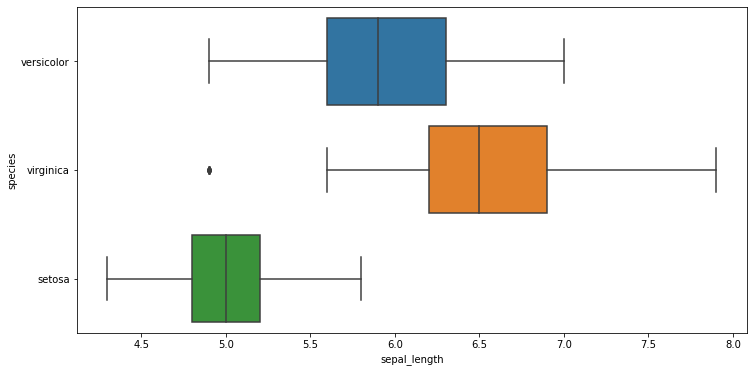

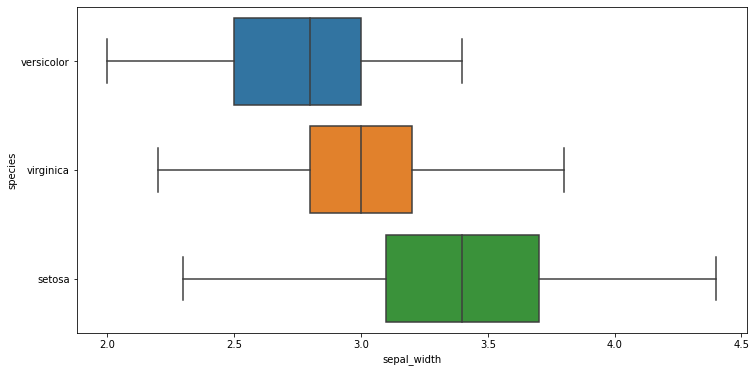

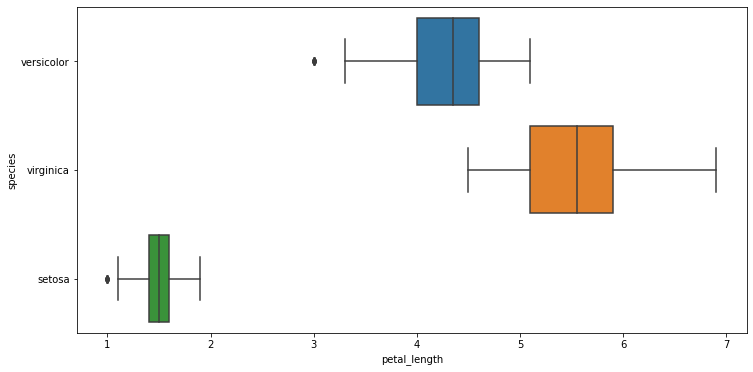

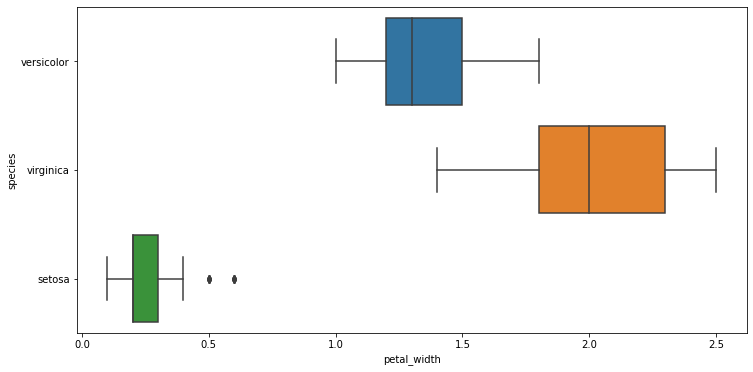

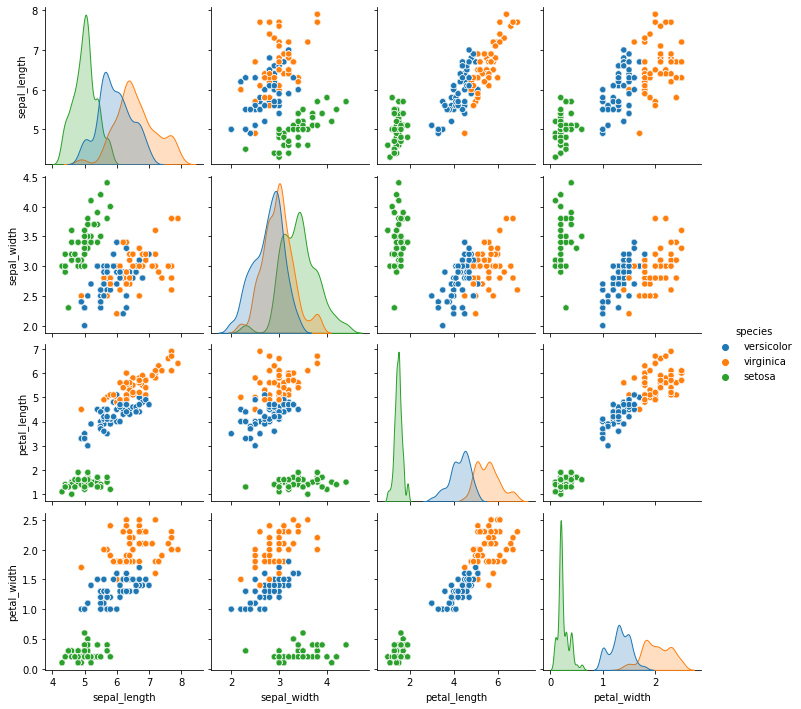

In [18]:
# boxplot(x='sepal length (cm)')
plt.figure(figsize = (12,6))
sns.boxplot(x='sepal_length', y='species', data=df, orient='h');

# boxplot(x='sepal width (cm)')
plt.figure(figsize = (12,6))
sns.boxplot(x='sepal_width', y='species', data=df, orient='h');

# boxplot(x='petal length (cm)')
plt.figure(figsize = (12,6))
sns.boxplot(x='petal_length', y='species', data=df, orient='h');

# boxplot(x='petal width (cm)')
plt.figure(figsize = (12,6))
sns.boxplot(x='petal_width', y='species', data=df, orient='h');

# pairplot
sns.pairplot(df, hue='species');

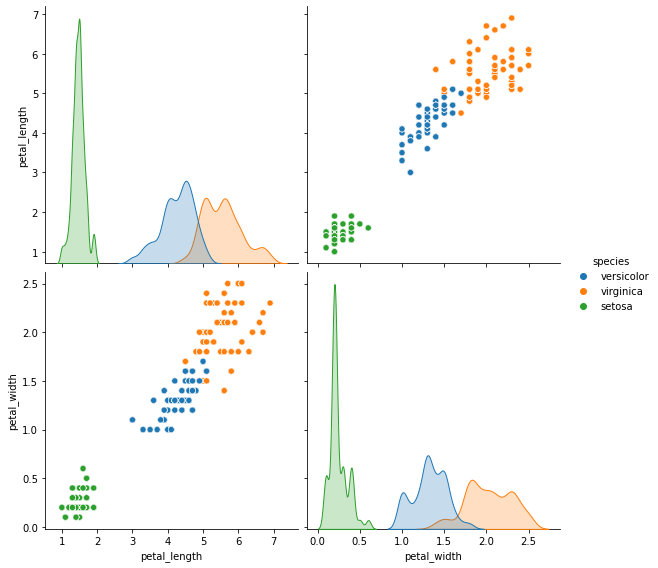

In [19]:
sns.pairplot(data=df, vars=['petal_length', 'petal_width'], hue='species', height=4);

In [20]:
feature_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
df_feature = df[feature_names]

In [21]:
df_label = df[['species']]

### 데이터셋 분리

In [54]:
X_train, X_test, y_train, y_test = train_test_split(df_feature.to_numpy(),
                                                    df_label.to_numpy(),
                                                    test_size=0.3,
                                                    random_state=42)

In [55]:
# 잘 나눠줬나 확인

# train 데이터 세트확인하기
print(X_train.shape)
print(y_train.shape)

# test 데이터 세트확인하기
print(X_test.shape)
print(y_test.shape)

(1050, 4)
(1050, 1)
(450, 4)
(450, 1)


### DecisionTreeClassifier

In [48]:
decision_tree = DecisionTreeClassifier(random_state=32)
print(decision_tree._estimator_type)

decision_tree.fit(X_train, y_train)

classifier


DecisionTreeClassifier(random_state=32)

### 모델 평가

In [56]:
y_pred = decision_tree.predict(X_test)
y_pred

y_test

from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, y_pred)
accuracy

1.0

In [57]:
# train, test 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(df_feature.to_numpy(), 
                                                    df_label.to_numpy(),
                                                    test_size=0.2, 
                                                    random_state=7)

# 모델 학습 및 예측
decision_tree = DecisionTreeClassifier(random_state=32)
decision_tree.fit(X_train, y_train)
y_pred = decision_tree.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        97
  versicolor       1.00      1.00      1.00       105
   virginica       1.00      1.00      1.00        98

    accuracy                           1.00       300
   macro avg       1.00      1.00      1.00       300
weighted avg       1.00      1.00      1.00       300



### RandomForest

In [27]:
# train, test 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(df_feature.to_numpy(), 
                                                    df_label.to_numpy(),
                                                    test_size=0.2, 
                                                    random_state=21)

# 모델 학습 및 예측
random_forest = RandomForestClassifier(random_state=32)
random_forest.fit(X_train, y_train)
y_pred = random_forest.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00       103
  versicolor       1.00      1.00      1.00        88
   virginica       1.00      1.00      1.00       109

    accuracy                           1.00       300
   macro avg       1.00      1.00      1.00       300
weighted avg       1.00      1.00      1.00       300



### Logistic Regression

In [28]:
# 모델 학습 및 예측
logistic_model = LogisticRegression()

logistic_model.fit(X_train, y_train)
y_pred = logistic_model.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00       103
  versicolor       0.98      0.95      0.97        88
   virginica       0.96      0.98      0.97       109

    accuracy                           0.98       300
   macro avg       0.98      0.98      0.98       300
weighted avg       0.98      0.98      0.98       300



### Support Vector Machine

In [29]:
# 모델 학습 및 예측
svm_model = svm.SVC()

svm_model.fit(X_train, y_train)
y_pred = svm_model.predict(X_test)

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00       103
  versicolor       1.00      0.95      0.98        88
   virginica       0.96      1.00      0.98       109

    accuracy                           0.99       300
   macro avg       0.99      0.98      0.99       300
weighted avg       0.99      0.99      0.99       300



In [ ]:
!pip install keras tensorflow

  Using cached tensorflow-2.9.1-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (511.7 MB)
  Using cached libclang-14.0.6-py2.py3-none-manylinux2010_x86_64.whl (14.1 MB)
  Using cached termcolor-1.1.0-py3-none-any.whl
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached flatbuffers-1.12-py2.py3-none-any.whl (15 kB)
  Using cached gast-0.4.0-py3-none-any.whl (9.8 kB)
  Using cached tensorflow_estimator-2.9.0-py2.py3-none-any.whl (438 kB)
  Using cached protobuf-3.19.4-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.1 MB)
  Using cached tensorboard-2.9.1-py3-none-any.whl (5.8 MB)
  Using cached absl_py-1.2.0-py3-none-any.whl (123 kB)
  Using cached numpy-1.21.6-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (15.7 MB)
  Using cached Keras_Preprocessing-1.1.2-py2.py3-none-any.whl (42 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
  Using cached tensorflow_io_gcs_filesystem-0.26.0-cp37-cp37m-manylinux_2_12_x86_64.manyl

### 미래에셋증권 빅데이터 페스티벌 공통 데이터 불러오기

In [ ]:
# Load dataset
mirae_ds = pd.read_csv("gs://cokebox-vertexai/data/finance_data.csv")

In [ ]:
mirae_ds.head()

In [ ]:
# Select top 3000 rows of dataset
TRAINING_SIZE = 100
DATASET_ID = 'bqml_tutorial'

query = f"""
        SELECT *
        FROM {IMPORT_FILE}
        LIMIT {TRAINING_SIZE}
        """


TRAINING_INPUT_TABLE_ID = f"{PROJECT_ID}.{DATASET_ID}.finance_data"

In [ ]:
job_config = bigquery.QueryJobConfig(destination=TRAINING_INPUT_TABLE_ID)

query_job = bq_client.query(query, job_config=job_config)  # API request
query_job.result()  # Waits for query to finish